# 210327 Fix problem species

In [1]:
using JSON
using Mmap
using CSV
using LinearAlgebra
using Printf

In [2]:
using ProgressMeter
using DataFrames
using FilePathsBase
using FilePathsBase: /
import Clustering  # to use ClusterAnalysis.hclust
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14144467868979587826\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3698376741747571412\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14144467868979587826\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Midas.Pairwise: npairs, iterpairs
using TriMatrices
using ClusterAnalysis
using MidasPlots
using MidasPlots.Plotly

## Setup

In [4]:
ENV["COLUMNS"] = 400

400

In [5]:
DATESTR = "210327"
NBNAME = "$DATESTR-fix-problem-species"

"210327-fix-problem-species"

In [6]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :formatted => p"data-intermediate/210303-format-data/",
    :overlaps => p"data-intermediate/210323-find-species-overlaps/",
);

In [7]:
intermediate_out = p"data-intermediate" / NBNAME
isdir(intermediate_out) || mkdir(intermediate_out)

reports_out = p"reports" / NBNAME
isdir(reports_out) || mkdir(reports_out)

true

## Load data

### Database

In [8]:
genomes_df = hcat(
    DataFrame(CSV.File(infiles[:formatted] / "genomes-v1.1.csv")),
    DataFrame(CSV.File(infiles[:overlaps] / "genomes-addendum.csv")),
)
insertcols!(genomes_df, 1, :index => axes(genomes_df, 1))

ngenomes = nrow(genomes_df)

50752

In [9]:
species_df = hcat(
    DataFrame(CSV.File(infiles[:formatted] / "species-v1.2.csv")),
    DataFrame(CSV.File(infiles[:overlaps] / "species-addendum.csv")),
)
insertcols!(species_df, 1, :index => axes(species_df, 1))

nspecies = nrow(species_df)

1438

In [10]:
genera_df = DataFrame(CSV.File(infiles[:formatted] / "genera-v1.2.csv"))

ngenera = nrow(genera_df)

462

In [11]:
gidxs_by_species = [Int[] for i in 1:nspecies]

for (i, si) in enumerate(genomes_df[!, :species_v12_idx1])
    si == 0 || push!(gidxs_by_species[si], i)
end

### Overlaps

In [12]:
overlap_pairs = [
    row[:src] => row[:dst]
    for row in eachrow(DataFrame(CSV.File(infiles[:overlaps] / "species-overlaps.csv")))
];

### Distances

In [13]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

In [14]:
species_pw_dists(i::Integer, j::Integer) = view(pw_dists, gidxs_by_species[i], gidxs_by_species[j])
species_pw_dists(ii, jj) = mortar([species_pw_dists(i, j) for i in ii, j in jj])

species_pw_dists (generic function with 2 methods)

In [15]:
species_pw_min_dists = zeros(Float32, nspecies, nspecies)

@showprogress for (i, j) in iterpairs(nspecies)
    species_pw_min_dists[i, j] = species_pw_min_dists[j, i] = minimum(species_pw_dists(i, j))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12:11


In [16]:
findmin2(a::AbstractVector; kw...) = partialsortperm(a, 2; kw...)
minimum2(a::AbstractVector; kw...) = a[findmin2(a; kw...)]

minimum2 (generic function with 1 method)

In [17]:
species_min_inter_idxs = findmin2.(eachrow(species_pw_min_dists))
species_min_inter_dists = [species_pw_min_dists[i, idx] for (i, idx) in enumerate(species_min_inter_idxs)];

## Identify species with outgoing overlaps to other genera

### Exclude specific pairs of genera from search

In [18]:
excluded_genus_pairs = Tuple{Int, Int}[];

Exclude Escherichia/Shigella overlaps, we know E. coli will overlap Shigella and that untangling it is going to be difficult.

In [19]:
let
    idx1 = findfirst(==("Escherichia"), genera_df[!, :name])
    idx2 = findfirst(==("Shigella"), genera_df[!, :name])
    push!(excluded_genus_pairs, Tuple(genera_df[[idx1, idx2], :db_id]))
end;

### Find problem species

In [20]:
genus_overlap_pairs = Pair{Int, Int}[]

for (src, dst) in overlap_pairs
    g1 = species_df[src, :genus_id]
    g2 = species_df[dst, :genus_id]
    
    (g1 != g2 &&
        (g1, g2) ∉ excluded_genus_pairs &&
        (g2, g1) ∉ excluded_genus_pairs &&
        push!(genus_overlap_pairs, src => dst))
end

problem_species = unique(first.(genus_overlap_pairs));

In [21]:
species_df[problem_species, :]

8×13 DataFrame
 Row │ index  db_id  taxid   name                         genus_id  ngenomes  migration_src_idxs1  migration_single_src  migration_identical  migration_1to1  diameter  outgoing_overlaps  incoming_overlaps 
     │ Int64  Int64  Int64   String                       Int64     Int64     String               Bool                  Bool                 Bool            Float64   Int64              Int64             
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   439   1460   28901  Salmonella enterica               157      4650  1153                                 true                 true            true  0.960833                 19                  2
   2 │   491   1201    2702  Gardnerella vaginalis             169        42  521                                  true                 true            true  0.998719                384                  1
   3 │   876    803    1219  Prochlorococcus marinus           308        29  1020                                 true                 true            true  0.998967               1371                  1
   4 │  1055    899    1396  Bacillus cereus                   350       196  127                                  true                 true            true  0.902063                  4                  4
   5 │  1127    929    1491  Clostridium botulinum             373       116  355                                  true                 true            true  0.994352                 32                  3
   6 │  1275   1622  169292  Corynebacterium aurimucosum       413         6  374                                  true                 true            true  0.992556                 36                  3
   7 │  1277   1628   38289  Corynebacterium jeikeium          413        19  385                                  true                 true            true  0.994414                108                  3
   8 │  1356   1405  413502  Cronobacter turicensis            437         4  404                                  true                 true            true  0.971022                 14                  2

In [22]:
genus_overlap_min_dists = Dict(si => Inf for si in problem_species)

for (src, dst) in genus_overlap_pairs
    genus_overlap_min_dists[src] = min(genus_overlap_min_dists[src], species_pw_min_dists[src, dst])
end

## Plot clustermaps

In [23]:
function style_dendrogram!(pdg::PlotlyDendrogram, ta::TreeAnnotations)
    pdg.nodes_trace[:hovertemplate] = """
    ID: %{customdata[0]}<br>
    Height: %{$(pdg.horizontal ? "x" : "y"):.3f}<br>
    Genome count: %{customdata[1]}
    <extra></extra>
    """
    
    vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
        node = ta.tree.nodes[id]
        return Dict(
            :customdata => [id, node.count]
        )
    end
    
    if "strong_cluster" in names(ta.node_attrs)
        pdg.nodes_trace[:marker_size] = map(pdg.node_ids) do id
            nodeattrs(ta, id, :strong_cluster) ? 8 : 4
        end
    end
    
    return pdg
end

style_dendrogram! (generic function with 1 method)

In [24]:
trees = Dict()
annotations = Dict()

for si in problem_species
    dmat = species_pw_dists(si, si)
    tree = trees[si] = ClusterAnalysis.hclust(dmat, linkage=:complete)
    ta = annotations[si] = TreeAnnotations(tree, :dmat => dmat)
    annotate!(:strong_cluster, ta)
end

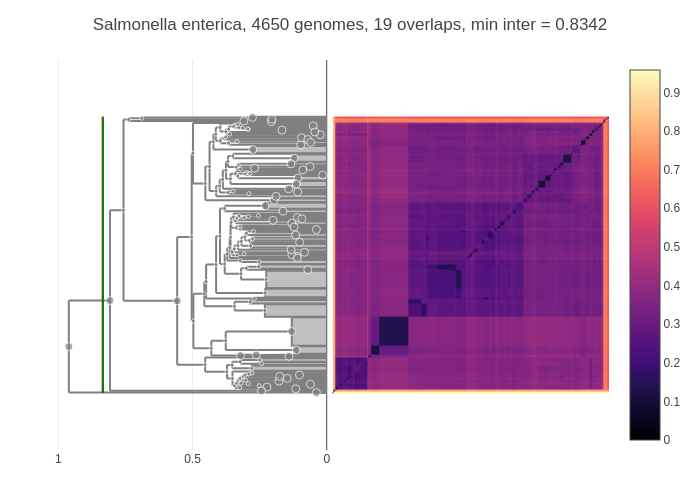

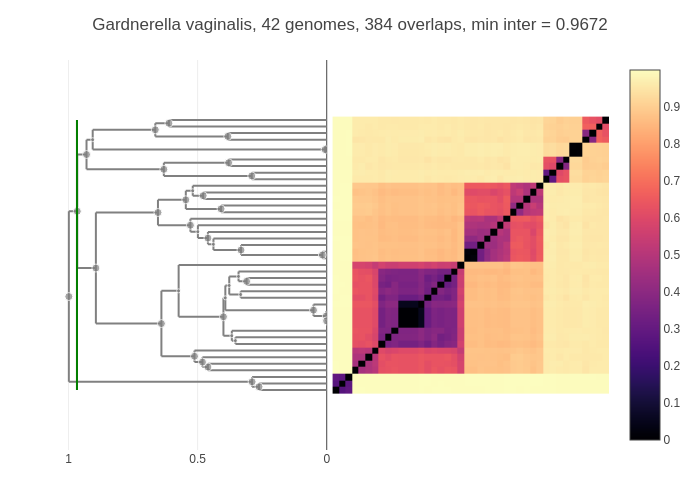

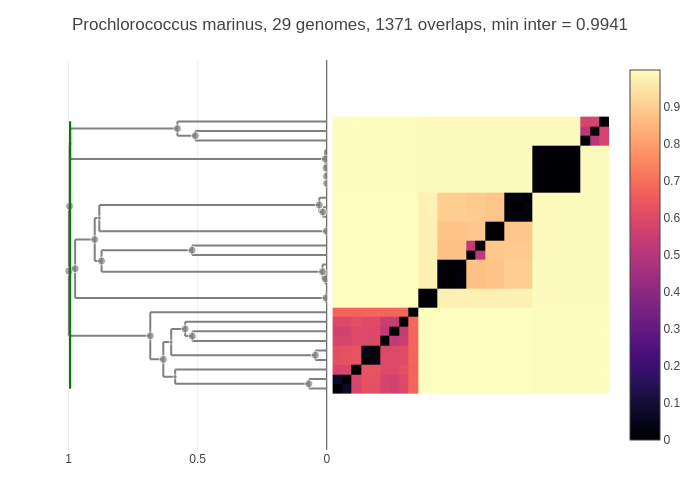

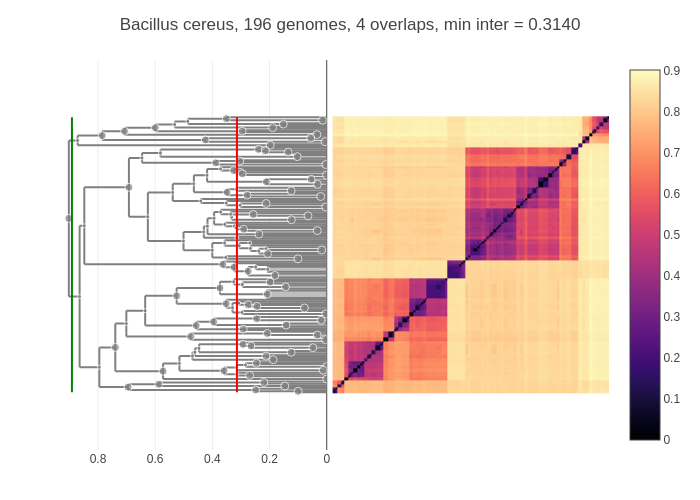

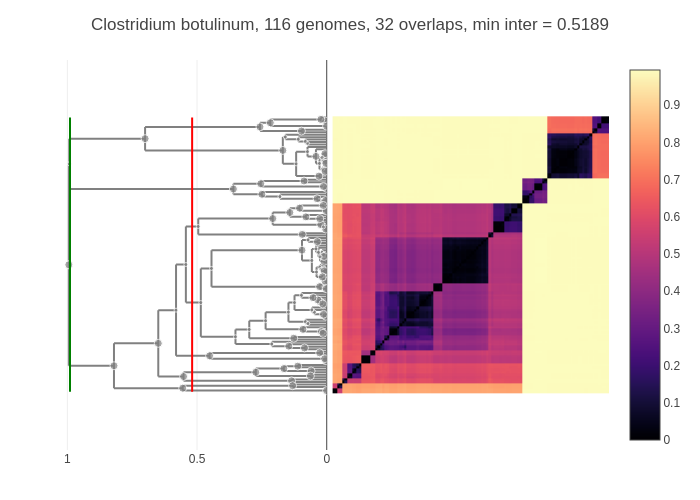

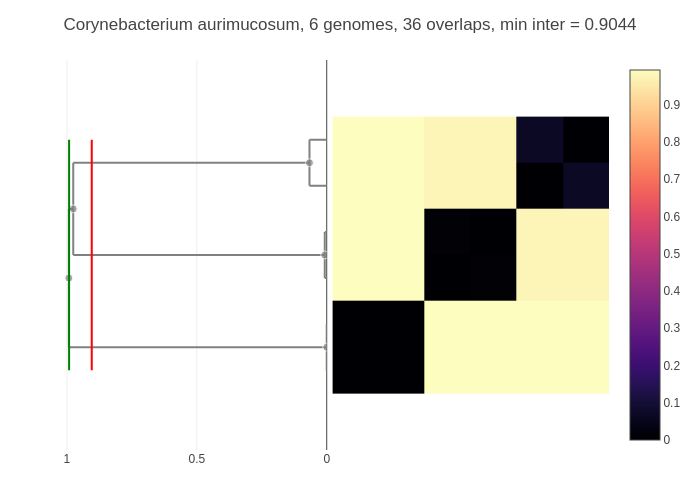

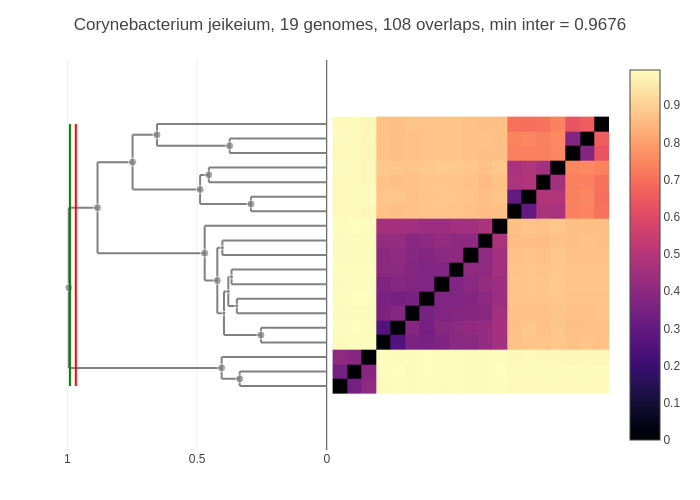

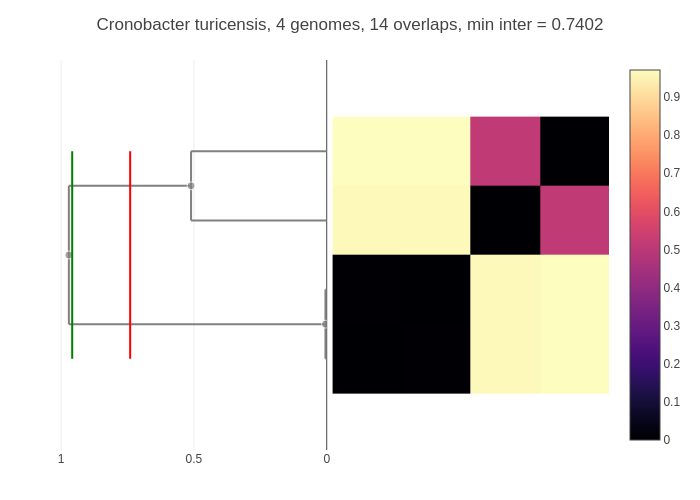

In [25]:
MAX_LEAVES = 100

for si in problem_species
    row = species_df[si, :]
    
    dmat = species_pw_dists(si, si)
    tree = trees[si]
    
    if ClusterAnalysis.nleaves(tree) <= MAX_LEAVES
        dg = Dendrogram(tree)
        dmat_ordered = false
    else
        cut = coarsen_cut(tree, ClusterAnalysis.leafids(tree), k=MAX_LEAVES)
        dg = Dendrogram(tree, trunc=node -> node.id ∈ cut)
        dmat = ClusterAnalysis.hclust_node_dists(tree, dmat, dg.leaves)
        dmat_ordered = true
    end
    
    pcm = symmetric_clustermap(dmat, dg, dg_frac=0.5, ordered=dmat_ordered)
    
    pcm.heatmap[:colorscale] = make_colorscale(:magma)
    
    style_dendrogram!(pcm.row_dg, annotations[si])
    
    merge!(pcm.layout, attr(
        title=@sprintf("%s, %d genomes, %d overlaps, min inter = %.4f", row[:name], row[:ngenomes], row[:outgoing_overlaps], species_min_inter_dists[si]),
        width=1000,
        height=550,
    ))
    
    plt = Plot(pcm)
    
    for (x, color) in [(species_min_inter_dists[si], :red), (genus_overlap_min_dists[si], :green)]
        addtraces!(plt, scatter(
            x=fill(x, 2),
            y=[dg.nodes[first(dg.leaves)].left, dg.nodes[last(dg.leaves)].right],
            xaxis="x2",
            mode=:lines,
            line_color=color,
            hoverinfo=:skip
        ))
    end
    
    display(plot(plt))
    
    fname = @sprintf "%d-%s.html" si replace(lowercase(species_df[si, :name]), ' ' => '-')
    savefig(plt, string(reports_out / fname))
end;

## Fixes

In [26]:
deleted_genomes = Set{Int}()

threshold_assignments = Dict{Int, Float64}()

species_splits = Dict{Int, Any}();

In [27]:
function remove_subtrees(si, ids)
    gidxs = gidxs_by_species[si]
    tree = trees[si]
    
    to_delete = Set{Int}()
    for id in ids
        subtree_genomes = gidxs[ClusterAnalysis.leaves(tree, id)]
        union!(to_delete, subtree_genomes)
    end
    
    remaining = collect(setdiff(gidxs, to_delete))
    
    println("# to delete: ", length(to_delete))
    println("Diameter after deletion: ", maximum(view(pw_dists, remaining, remaining)))
    
    union!(deleted_genomes, to_delete)
    nothing
end

remove_subtrees (generic function with 1 method)

In [28]:
function keep_subtrees(si, ids)
    gidxs = gidxs_by_species[si]
    tree = trees[si]
    
    to_keep = Set{Int}()
    for id in ids
        subtree_genomes = gidxs[ClusterAnalysis.leaves(tree, id)]
        union!(to_keep, subtree_genomes)
    end
    
    to_delete = collect(setdiff(gidxs, to_keep))
    to_keep = collect(to_keep)
    
    println("# to delete: ", length(to_delete))
    println("Diameter after deletion: ", maximum(view(pw_dists, to_keep, to_keep)))
    
    union!(deleted_genomes, to_delete)
    nothing
end

keep_subtrees (generic function with 1 method)

In [29]:
function split_species(si, root_ids)
    gidxs = gidxs_by_species[si]
    tree = trees[si]
    
    species_splits[si] = [gidxs[leaves(tree, id)] for id in root_ids]
    
    for (i, gg) in enumerate(species_splits[si])
        println("Subgroup $i size: ", length(gg))
    end
    
    to_delete = setdiff(gidxs, species_splits[si]...)
    println("Genomes to delete: ", length(to_delete))
    
    union!(deleted_genomes, to_delete)
    nothing
end

split_species (generic function with 1 method)

### Salmonella enterica

Diameter of species can be reduced from .961 to .557 by removing the 23 genomes outsides of subtree 9294.

In [30]:
keep_subtrees(439, 9294)

# to delete: 23
Diameter after deletion: 0.5571412


### Gardnerella vaginalis

Removing outlier-ish subcluster 49 (3 genomes) cuts diameter down to 0.966, just under min inter of .9672. This would remove all overlaps, not just to species in other genera.

In [31]:
remove_subtrees(491, 49)

# to delete: 3
Diameter after deletion: 0.96604276


### Prochlorococcus marinus

The worst offender, huge diameter of .999 means it overlaps with almost everything. Not caused by any obvious outlier group, can split up into pretty distinct subgroups of sizes 12, 9, 5, and 3. This should remove all overlaps.

In [32]:
split_species(876, [54, 50, 35, 46])

Subgroup 1 size: 12
Subgroup 2 size: 9
Subgroup 3 size: 5
Subgroup 4 size: 3
Genomes to delete: 0


### Bacillus cereus

A lot of substructure here. Basically decompose into 4 largest "strong" subclusters, throw a small number of genomes out. Avoids overlaps to other genera by a wide margin, may still have some within Bacillus.

In [33]:
split_species(1055, [385, 381, 386, 349])

Subgroup 1 size: 82
Subgroup 2 size: 71
Subgroup 3 size: 16
Subgroup 4 size: 18
Genomes to delete: 9


### Clostridium botulinum

Split into 3 very well-separated subgroups, no genomes left out.

In [34]:
split_species(1127, [229, 228, 218])

Subgroup 1 size: 80
Subgroup 2 size: 26
Subgroup 3 size: 10
Genomes to delete: 0


### Corynebacterium aurimucosum

Contains three pairs at distances of .066, .008, and .000 (identical, one will need to be removed), top-level branches at heights of .993 and .976. Doesn't really seem like a proper species. Closest other species at distance of .904, going to arbitrarily set threshold of .75 right now and revisit issue later.

In [35]:
threshold_assignments[1275] = .75

0.75

### Corynebacterium jeikeium

3 of 19 genomes in pretty clear outlier cluster, remaining have diameter .884 which would fix all overlaps. Remove these.

In [36]:
remove_subtrees(1277, 29)

# to delete: 3
Diameter after deletion: 0.88382953


### Cronobacter turicensis

Two pairs with diameters .511 and .005, distance .971 apart. Just set threshold to .6 (removes all overlaps), should probably revisit later.

In [37]:
threshold_assignments[1356] = .6;

## Save data

### Problem species and associated data

In [38]:
let
    items = map(problem_species) do si
        si => Dict(
            :index => si,
            :db_id => species_df[si, :db_id],
            :diameter => species_df[si, :diameter],
            :genus_overlaps => Any[],
            :closest_species => Dict(
                :index => species_min_inter_idxs[si],
                :distance => species_min_inter_dists[si],
            ),
        )
    end |> Dict
    
    for (src, dst) in genus_overlap_pairs
        push!(
            items[src][:genus_overlaps],
            Dict(
                :index => dst,
                :distance => species_pw_min_dists[src, dst],
            ),
        )
    end
    
    open(intermediate_out / "problem-species.json", "w") do f
        JSON.print(f, collect(values(items)))
    end
end

### Fixes

In [39]:
let
    data = Dict(
        "deleted_genomes" => collect(deleted_genomes),
        "threshold_assignments" => [
            Dict("species_index" => si, "threshold" => thresh)
            for (si, thresh) in threshold_assignments
        ],
        "species_splits" => map(collect(species_splits)) do (si, subgroup_idxs)
            tree = trees[si]
            Dict("species_index" => si, "subgroup_genomes" => subgroup_idxs)
        end
    )
    
    open(intermediate_out / "fixes.json", "w") do f
        JSON.print(f, data)
    end
end